In [2]:
'''
predict with ARIMA
'''

import pandas as pd
import os
import numpy as np


data_raw = pd.read_csv('../result/v0_road_status.csv', index_col=None)
data_raw

,nonempty_road,vehicle_num
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
20605,1,4
20606,1,4
20607,1,4
20608,1,3


In [2]:
'''
total data samples: 20595 , testing data samples: 4199
'''
split = 0.2
df_train= data_raw.nonempty_road[int(split*data_raw.shape[0]):]
df_test = data_raw.nonempty_road[:int(split*data_raw.shape[0])-3] 
df_test.shape ## 4119

(4119,)

In [3]:
## Stationarity checking  (conclusion: The p-value -5.1894 is less than the significance level of 0.05 \
##                     and hence we can reject the null hypothesis and take that the series is stationary,\
##                     i.e. not stable, so use order 1)
## refer: https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/

import statsmodels
import statsmodels.api as sm
statsmodels.tsa.stattools.adfuller(df_train,
maxlag = None,regression ='c',autolag ='AIC',
store = False,regresults = False )

(-4.959032831716812,
 2.6731684614154435e-05,
 44,
 16443,
 {'1%': -3.430747757170451,
  '5%': -2.861715792595249,
  '10%': -2.5668635699588016},
 -50891.139367938435)

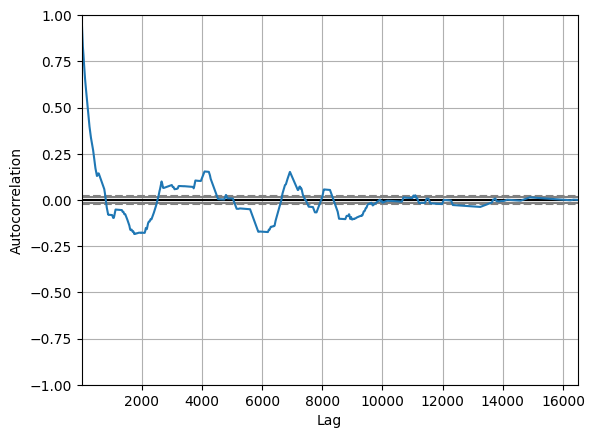

In [4]:
## autocorrelation check

from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df_train[:])
pyplot.show()

In [5]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_train, order=(5,0,1))  ##order of the model for the autoregressive, differences, and moving
model_fit = model.fit()
print(model_fit.summary())

/home/royliu/Downloads/yes/envs/py310/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/royliu/Downloads/yes/envs/py310/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/royliu/Downloads/yes/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:          nonempty_road   No. Observations:                16488
Model:                 ARIMA(5, 0, 1)   Log Likelihood               25475.270
Date:                Thu, 14 Mar 2024   AIC                         -50934.540
Time:                        13:23:51   BIC                         -50872.857
Sample:                             0   HQIC                        -50914.169
                              - 16488                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8378      0.167      5.023      0.000       0.511       1.165
ar.L1         -0.1276      0.061     -2.080      0.038      -0.248      -0.007
ar.L2          0.7892      0.039     20.030      0.0

In [6]:
## predict
y_pred_prob = model_fit.forecast(len(df_test), alpha=0.05) # 95% conf
y_pred_prob =y_pred_prob.tolist()
y_target = df_test.tolist()

/home/royliu/Downloads/yes/envs/py310/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [7]:
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score
threshold=0.8377528397  ## fine tunned
y_pred = [1 if y_pred_prob[j] > threshold else 0 for j in range(len(y_pred_prob))]
acc = accuracy_score(y_target, y_pred)
f1_score = f1_score(y_target, y_pred)
recall = recall_score(y_target, y_pred)
precision = precision_score(y_target, y_pred)
print(f'Acc: {acc}, f1: {f1_score}, recall: {recall}, precision: {precision}')

Acc: 0.8135469774217043, f1: 0.8971887550200803, recall: 0.8795275590551181, precision: 0.9155737704918033


sklearn Acc: 0.813547, Recall: 0.879528, Precision: 0.915574, F1: 0.897189 


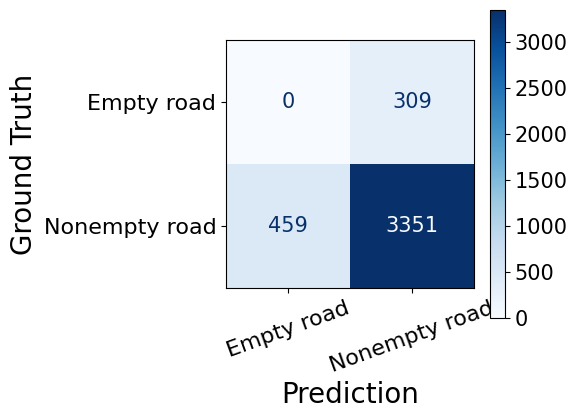

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score,accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(labels, pred_labels, classes):
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels=classes)
    
    cm.plot(values_format='d', cmap='Blues', ax=ax)
    plt.xticks(rotation=20, fontsize=16)
    plt.yticks( fontsize=16)
    ax.set_xlabel('Prediction',fontsize=20);ax.set_ylabel('Ground Truth',fontsize=20)
    plt.rcParams.update({'font.size': 15}) ## change the font size in matrix
    plt.show()
    plot_dir = '../result/' #ubuntu
    cm.figure_.savefig(plot_dir+'confusion_matrix_arima.pdf',bbox_inches='tight')

classes = ['Empty road', 'Nonempty road']
# preds = get_predictions(model, X_test, device)

print('sklearn Acc: %f, Recall: %f, Precision: %F, F1: %f '% (accuracy_score(y_target, y_pred),\
    recall_score(y_target, y_pred), precision_score(y_target, y_pred), f1_score(y_target, y_pred)))
plot_confusion_matrix(y_target, y_pred, classes)
